### Imports

In [1]:
import pandas as pd
import os
from pathlib import Path
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Input Raw File and Decoder File

In [64]:
files = [
    "QCHWK",
    "QCHWQ",
    "QCHXD",
    "QCHXG",
    "QCHXL",
    "QCHXM",
    "QCHXV",
    "QCHXW",
    "QCHXX",
    "QCHY1",
    "QCHY2",
    "QCHY6",
    "QCHY7",
    "QCHY8",
    "QCHYG",
    "QCHYH",
    "QCHYK",
    "QCHYR",
    "QCHYS",
    "QCHYT",
    "QCHZ1",
    "QCHZ5",
    "QCHZ6",
    "QCHZ8",
    "QCHZH",
]  # List of wafer codes

summaryfile_name = "debug"

decoder_file = "QC WAFER_LAYOUT 24Dec.csv"
# Define the current script's directory
current_dir = Path(os.getcwd())
# Move to the root directory
root_dir = current_dir.parents[0]  # Adjust the number based on your folder structure
# Define the path to the required subfolder
file_paths = []
for wafer_code in files:
    for file in os.listdir(root_dir / "LIV_Raw_Files"):
        if wafer_code in file and "COD250" in file:
            file_paths.append(root_dir / "LIV_Raw_Files" / file)
decoder_file_path = root_dir / "decoders" / decoder_file
cod_summary_file_path = root_dir / "cod_summaries"
print(file_paths)

[WindowsPath('c:/Users/762093/OneDrive - Seagate Technology/Documents/LIV/liv-cod-algorithm/LIV_Raw_Files/LIV_53_QCHWK_DNS-LIVTKCOD_LCRVCOD250-DNS_RAW20250219183049.csv')]


# Transform Data to Desired Raw Sweep Format

- selects required columns
- transposes
- stacks data in tall format
- adds in device coords from decoder file
- loops for every csv file chosen, and stores raw_sweep dataframes

In [65]:
# Transforming Raw File Code
warnings.filterwarnings("ignore")

raw_sweeps_tables = []

for file_path in file_paths:
    # Read the CSV file, skipping the first 19 rows
    df = pd.read_csv(file_path, skiprows=19)
    # Read the CSV file again to extract the second row
    header_df = pd.read_csv(file_path, nrows=2)
    # Extract the wafer id from the second row
    wafer_id = header_df.iloc[1, 1]
    # Print the wafer id for verification
    print(f"Wafer ID: {wafer_id}")
    # Get the directory of the file
    folder = file_path.parent
    print(f"Directory: {folder}")
    # Get column names
    col_names = df.columns
    # Find columns containing "Vf" or "PD"
    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]
    # Subset the data frame with selected columns
    df_subset = df[selected_cols]
    # Find and delete columns containing "Vf@" or "PD@"
    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]
    df_subset.drop(columns=cols_to_delete, inplace=True)
    # Transpose the data frame
    df_transposed = df_subset.transpose()
    # Reset index to make the transposed columns into rows
    df_transposed.reset_index(inplace=True)
    # Add a new row at the top with the desired titles
    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns
    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index
    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top
    # Display the first 10 rows of df_transposed
    df_transposed.head(10)
    # df_subset.head(10)
    # Split transposed table into Vf and PD data tables
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]
    # df_vf.head(10)
    # df_pd.head(10)
    # Drop the 'Label' column
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)
    # learn data dimensions
    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")
    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")
    # Concatenate all Voltage columns into one
    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")
    # Create TOUCHDOWN column
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]
    # Concatenate all PD columns into one
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")
    # Cartesian join of Vf and PD data tables
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)
    # df_raw_sweeps.head(270)
    # Add device coordinates from original RAW file
    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left")
    else:
        print("Required columns for merging device coordinates are missing in the original RAW file.")
    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)
        # Update with decoder to get TE_LABEL etc.
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:
            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")
    # Rename the columns
    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)
    # Add current column as a repeating sequence of length n_meas
    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]
    # Add a column for WAFER_ID with the wafer_id value repeated for every row
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)
    raw_sweeps_tables.append(df_raw_sweeps)

# Display the first 10 rows of df_raw_sweeps
raw_sweeps_tables[0].head(379500)

Wafer ID: QCHWK
Directory: c:\Users\762093\OneDrive - Seagate Technology\Documents\LIV\liv-cod-algorithm\LIV_Raw_Files
Number of Current Measurements per Device: 250
Number of Devices: 1288


,WAFER_ID,Vf,TOUCHDOWN,PD,X_UM,Y_UM,TE_LABEL,TYPE,LDI_mA
0,QCHWK,1.272589,1,0.168066,-32339,-48416,64N6V,BL LASER,1
1,QCHWK,1.388322,1,0.169577,-32339,-48416,64N6V,BL LASER,2
2,QCHWK,1.441653,1,0.172598,-32339,-48416,64N6V,BL LASER,3
3,QCHWK,1.469867,1,0.171087,-32339,-48416,64N6V,BL LASER,4
4,QCHWK,1.491745,1,0.169577,-32339,-48416,64N6V,BL LASER,5
...,...,...,...,...,...,...,...,...,...
321995,QCHWK,2.702859,1288,0.044277,41067,-60599,70C05,SILC,246
321996,QCHWK,2.706151,1288,0.047563,41067,-60599,70C05,SILC,247
321997,QCHWK,2.709907,1288,0.045920,41067,-60599,70C05,SILC,248
321998,QCHWK,2.712851,1288,0.049205,41067,-60599,70C05,SILC,249


# Delta Method COD Algorithm

 - calculates delta differentials
 - checks if a differential is below a certain threshold
 - this threshold is weighted by the mean PD

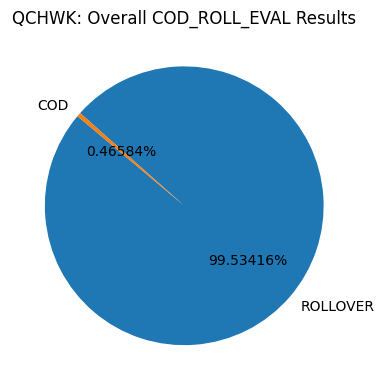

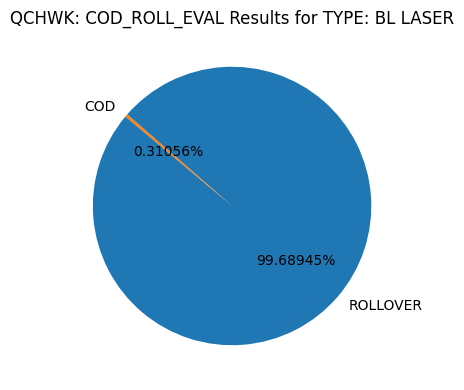

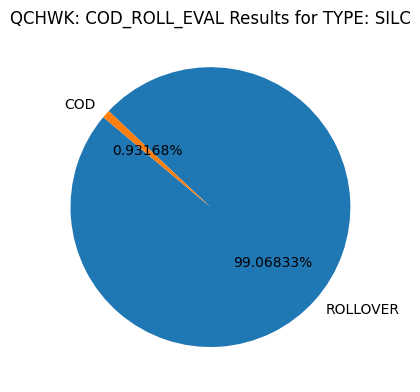

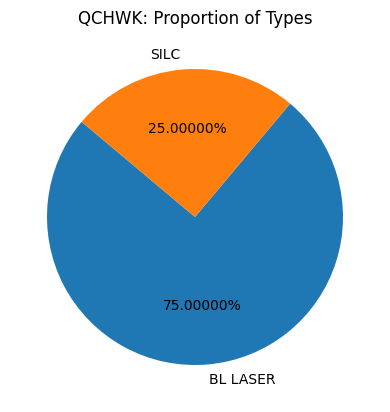

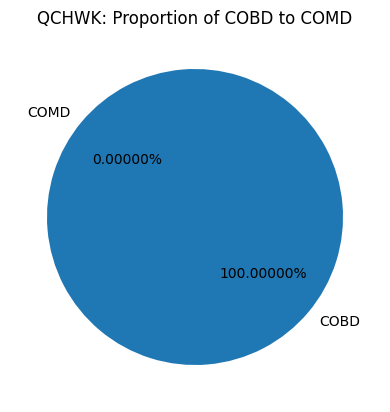

In [66]:
DELTA_ALGORITHM_MIN_DELTA = 0.4
DELTA_ALGORITHM_MAX_PD = 1


def raw_sweep_COD_evaluations(df_raw_sweeps, delta_algorithm_min_delta, delta_algorithm_max_pd):

    # Calculate dV/dI
    df_raw_sweeps["dV/dI"] = (df_raw_sweeps["Vf"].diff()) / (df_raw_sweeps["LDI_mA"].diff())
    # Calculate dP/dI
    df_raw_sweeps["DP/DI"] = (df_raw_sweeps["PD"].diff()) / (df_raw_sweeps["LDI_mA"].diff())
    # Calculate MAX_PD
    # print(df_raw_sweeps)
    df_raw_sweeps["MAX_PD"] = df_raw_sweeps.groupby(["TE_LABEL"])["PD"].transform("max")
    # print(df_raw_sweeps)
    # Calculate MEAN_PD
    df_raw_sweeps["MEAN_PD"] = df_raw_sweeps.groupby(["TE_LABEL"])["PD"].transform("mean")
    # Calculate DELTA
    df_raw_sweeps["DELTA"] = df_raw_sweeps["MEAN_PD"] - df_raw_sweeps["DP/DI"].abs()
    # Calculate MIN_DELTA
    df_raw_sweeps["MIN_DELTA"] = df_raw_sweeps.groupby(["TE_LABEL"])["DELTA"].transform("min")

    # MAIN CHECK OF IF COD'd
    # Calculate COD_ROLL_EVAL
    conditions = [
        (df_raw_sweeps["MIN_DELTA"] > delta_algorithm_min_delta),
        (df_raw_sweeps["MAX_PD"] < delta_algorithm_max_pd),
    ]
    choices = ["ROLLOVER", "NO LASER"]
    df_raw_sweeps["COD_ROLL_EVAL"] = np.select(conditions, choices, default="COD")

    # # Calculate the average of dV/dI for the current row, 2 rows ahead, and 2 rows behind
    # df_raw_sweeps["AVG_DV_DI"] = df_raw_sweeps["dV/dI"].rolling(window=5, center=True).mean()

    # Calculate
    # Can calculate this even if COD'd
    df_raw_sweeps["DEV_CURRENT_AT_PEAK_POWER"] = np.where(
        (df_raw_sweeps["PD"] == df_raw_sweeps["MAX_PD"]),  # Vupgrade
        df_raw_sweeps["LDI_mA"],
        np.nan,
    )
    # Calculate DEV_CURR_AT_SPD
    # looks for the point of lowest delta in PD curve
    df_raw_sweeps["DEV_CURR_AT_SPD"] = np.where(
        (df_raw_sweeps["DELTA"] == df_raw_sweeps["MIN_DELTA"]) & (df_raw_sweeps["COD_ROLL_EVAL"] == "COD"),  # Vupgrade
        df_raw_sweeps["LDI_mA"],
        np.nan,
    )
    # Calculate CURRENT_AT_ROLLOVER
    df_raw_sweeps["CURRENT_AT_PEAK_POWER"] = df_raw_sweeps.groupby(["TE_LABEL"])["DEV_CURRENT_AT_PEAK_POWER"].transform("median")
    # Calculate CURRENT_AT_SPD
    df_raw_sweeps["CURRENT_AT_SPD"] = df_raw_sweeps.groupby(["TE_LABEL"])["DEV_CURR_AT_SPD"].transform("median")
    df_raw_sweeps.drop(columns=["DEV_CURRENT_AT_PEAK_POWER", "DEV_CURR_AT_SPD"], inplace=True)

    # # Annotate the dV/dI value at the point of COD fail
    # df_raw_sweeps["DV_DI_AT_COD"] = np.where(
    #     (df_raw_sweeps["COD_ROLL_EVAL"] == "COD"),
    #     df_raw_sweeps["dV/dI"],
    #     np.nan,
    # )

    # Calculate POT_FAILMODE using the dV/dI
    # Calculates for only the Minimum Delta
    df_raw_sweeps["POT_FAILMODE"] = df_raw_sweeps["COD_ROLL_EVAL"]
    df_raw_sweeps.loc[(df_raw_sweeps["COD_ROLL_EVAL"] == "COD") & (df_raw_sweeps["DELTA"] == df_raw_sweeps["MIN_DELTA"]) & (df_raw_sweeps["dV/dI"] > 0), "POT_FAILMODE"] = "COMD"
    df_raw_sweeps.loc[(df_raw_sweeps["COD_ROLL_EVAL"] == "COD") & (df_raw_sweeps["DELTA"] == df_raw_sweeps["MIN_DELTA"]) & (df_raw_sweeps["dV/dI"] < 0), "POT_FAILMODE"] = "COBD"

    def set_failmode(group):
        if "COMD" in group["POT_FAILMODE"].values:
            group["POT_FAILMODE"] = "COMD"
        elif "COBD" in group["POT_FAILMODE"].values:
            group["POT_FAILMODE"] = "COBD"
        return group

    df_raw_sweeps = df_raw_sweeps.reset_index().groupby("TE_LABEL").apply(set_failmode).set_index("index")

    df_raw_sweeps = df_raw_sweeps.sort_values(["TOUCHDOWN", "LDI_mA"])  # resorts the data

    # # Flag lasers with multiple COD flags as 'M. COD' and single COD as 'COD'
    # cod_counts = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == "COD"].groupby("TE_LABEL").size()
    # multiple_cod_labels = cod_counts[cod_counts > 1].index.tolist()

    # def flag_cod(te_label, cod_roll_eval):
    #     if cod_roll_eval == "COD" and te_label in multiple_cod_labels:
    #         return "M. COD"
    #     return cod_roll_eval

    # df_raw_sweeps["COD_ROLL_EVAL"] = df_raw_sweeps.apply(lambda row: flag_cod(row["TE_LABEL"], row["COD_ROLL_EVAL"]), axis=1)
    return df_raw_sweeps


def generate_COD_device_summary_table(df_raw_sweeps):

    # Create COD Summary table with POT_FAILMODE
    device_summary = (
        df_raw_sweeps.groupby("TE_LABEL")
        .agg(
            {
                "WAFER_ID": "first",
                "TOUCHDOWN": "first",
                "TYPE": "first",
                "X_UM": "first",
                "Y_UM": "first",
                "COD_ROLL_EVAL": "first",
                "POT_FAILMODE": "first",
                "MAX_PD": "first",
                "MEAN_PD": "first",
                "MIN_DELTA": "first",
                "CURRENT_AT_PEAK_POWER": "first",
                "CURRENT_AT_SPD": "first",
            }
        )
        .reset_index()
    ).sort_values("TOUCHDOWN")
    return device_summary


def plot_pie_chart(data, title):
    plt.figure(figsize=(4, 4))
    plt.pie(
        data,
        labels=data.index,
        autopct="%1.5f%%",
        startangle=140,
    )
    plt.tight_layout()
    plt.title(title)
    plt.show()


def calculate_confidence_interval(cod_count, total_count, confidence_level=0.95):
    """
    Calculate the confidence interval for a proportion.
    """
    proportion = cod_count / total_count
    z = 1.96  # Z-score for 95% confidence interval
    margin_of_error = z * np.sqrt((proportion * (1 - proportion)) / total_count)
    lower_bound = proportion - margin_of_error
    upper_bound = proportion + margin_of_error
    return lower_bound * 100, upper_bound * 100


def generate_COD_wafer_summary(device_summary):
    wafer_code = device_summary["WAFER_ID"].iloc[0]

    # Calculate COD percentage for the wafer code
    cod_count = device_summary[device_summary["COD_ROLL_EVAL"] == "COD"].shape[0]
    total_count = device_summary.shape[0]
    cod_percentage = (cod_count / total_count) * 100 if total_count > 0 else 0

    # Calculate confidence interval
    lower_bound, upper_bound = calculate_confidence_interval(cod_count, total_count)

    # Count the number of ROLLOVERS, CODs, and NO LASERs
    rollover_count = device_summary[device_summary["COD_ROLL_EVAL"] == "ROLLOVER"].shape[0]
    no_laser_count = device_summary[device_summary["COD_ROLL_EVAL"] == "NO LASER"].shape[0]

    # Plot overall COD_ROLL_EVAL results
    overall_cod_roll_eval_counts = device_summary["COD_ROLL_EVAL"].value_counts()
    plot_pie_chart(overall_cod_roll_eval_counts, f"{wafer_code}: Overall COD_ROLL_EVAL Results")

    # Store COD proportions for each TYPE
    cod_proportions = {}
    types = device_summary["TYPE"].unique()
    for t in types:
        type_data = device_summary[device_summary["TYPE"] == t]
        type_cod_roll_eval_counts = type_data["COD_ROLL_EVAL"].value_counts()

        # Calculate proportions
        total_count = type_cod_roll_eval_counts.sum()
        cod_count = type_cod_roll_eval_counts.get("COD", 0)
        cod_proportion = (cod_count / total_count) * 100

        cod_proportions[t] = cod_proportion

        plot_pie_chart(type_cod_roll_eval_counts, f"{wafer_code}: COD_ROLL_EVAL Results for TYPE: {t}")

    # Proportion of Laser Types
    type_counts = device_summary["TYPE"].value_counts()
    plot_pie_chart(type_counts, f"{wafer_code}: Proportion of Types")

    # Calculate the proportion of COBD to COMD
    failmode_counts = device_summary["POT_FAILMODE"].value_counts()
    cobd_comd_counts = failmode_counts.reindex(["COBD", "COMD"], fill_value=0)
    cobd_percentage = (cobd_comd_counts["COBD"] / cobd_comd_counts.sum()) * 100 if cobd_comd_counts.sum() > 0 else 0
    comd_percentage = (cobd_comd_counts["COMD"] / cobd_comd_counts.sum()) * 100 if cobd_comd_counts.sum() > 0 else 0
    plot_pie_chart(cobd_comd_counts, f"{wafer_code}: Proportion of COBD to COMD")

    # Create the wafer summary table
    wafer_summary_table = pd.DataFrame(
        {
            "Wafer Code": [wafer_code, wafer_code, wafer_code],
            "COD Percentage": [cod_percentage, lower_bound, upper_bound],
            "ROLLOVER Count": [rollover_count, "", ""],
            "COD Count": [cod_count, "", ""],
            "NO LASER Count": [no_laser_count, "", ""],
            "COBD Percentage": [cobd_percentage, "", ""],
            "COMD Percentage": [comd_percentage, "", ""],
        }
    )

    # Add COD proportions for each TYPE to the table
    for t, proportion in cod_proportions.items():
        wafer_summary_table[f"COD {t} Percentage"] = [proportion, "", ""]

    return wafer_summary_table


annotated_sweeps_tables = []
device_summary_tables = []
wafer_summary_tables = []

for i, df_raw_sweeps in enumerate(raw_sweeps_tables):
    wafer_code = df_raw_sweeps["WAFER_ID"].iloc[0]
    df_raw_sweeps = raw_sweep_COD_evaluations(df_raw_sweeps, DELTA_ALGORITHM_MIN_DELTA, DELTA_ALGORITHM_MAX_PD)
    annotated_sweeps_tables.append(df_raw_sweeps)
    # Save each raw sweeps dataframe to a CSV file
    df_raw_sweeps.to_csv(cod_summary_file_path / f"{summaryfile_name}_{wafer_code}_raw_sweeps.csv", index=False)

    device_summary = generate_COD_device_summary_table(df_raw_sweeps)
    device_summary_tables.append(device_summary)
    # Save each device summary to a CSV file
    device_summary.to_csv(cod_summary_file_path / f"{summaryfile_name}_{wafer_code}_device_summary.csv", index=False)

    wafer_summary_table = generate_COD_wafer_summary(device_summary)
    wafer_summary_tables.append(wafer_summary_table)


# Concatenate all wafer summary tables into one dataframe
final_wafer_summary_table = pd.concat(wafer_summary_tables, ignore_index=True)

# Save the final wafer summary table to a CSV file
final_wafer_summary_table.to_csv(cod_summary_file_path / f"{summaryfile_name}_wafer_summary.csv", index=False)

## COD rate against type comparison

QCHWK: - Number of SILC devices: 322

QCHWK: - Number of BL LASER devices: 966

QCHWK: 
       TYPE  COD_prop       MSE
0      SILC  0.931677  0.535392
1  BL LASER  0.310559  0.179023



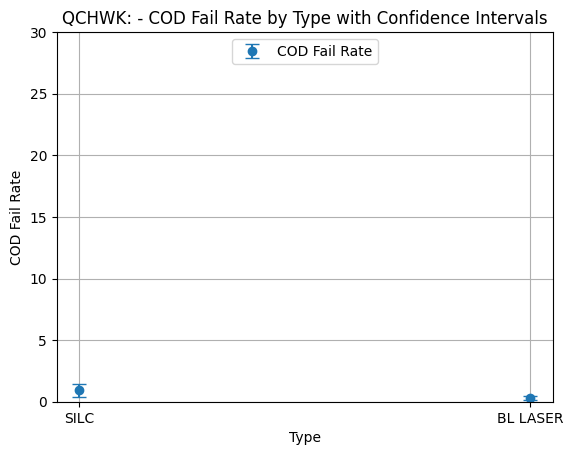

In [47]:
# Calculate the MSE error on the percentages using the proportion rule
def calculate_mse(p, n):
    return np.sqrt((p * (1 - p)) / n)


# Iterate over each raw sweeps dataframe in the list and calculate the MSE error on the percentages
for cod_summary in device_summary_tables:
    wafer_code = cod_summary["WAFER_ID"].iloc[0]
    mse_data = []
    for t in cod_summary["TYPE"].unique():
        type_data = cod_summary[cod_summary["TYPE"] == t]
        type_cod_roll_eval_counts = type_data["COD_ROLL_EVAL"].value_counts()

        # Calculate proportions
        total_count = type_cod_roll_eval_counts.sum()
        print(f"{wafer_code}: - Number of {t} devices: {total_count}\n")
        cod_count = type_cod_roll_eval_counts.get("COD", 0)
        cod_proportion = cod_count / total_count

        # Calculate MSE
        mse = calculate_mse(cod_proportion, total_count)

        mse_data.append((t, cod_proportion, mse))

    # Convert to DataFrame for easier plotting
    mse_df = pd.DataFrame(mse_data, columns=["TYPE", "COD_prop", "MSE"])
    mse_df["COD_prop"] = mse_df["COD_prop"] * 100
    mse_df["MSE"] = mse_df["MSE"] * 100

    print(f"{wafer_code}: \n{mse_df}\n")

    # Plot COD fail rate against type with confidence intervals annotated
    plt.figure()
    plt.errorbar(
        mse_df["TYPE"],
        mse_df["COD_prop"],
        yerr=mse_df["MSE"],
        fmt="o",
        capsize=5,
        label="COD Fail Rate",
    )
    plt.xlabel("Type")
    plt.ylabel("COD Fail Rate")
    plt.ylim([0, 30])
    plt.title(f"{wafer_code}: - COD Fail Rate by Type with Confidence Intervals")
    plt.legend(loc="upper center")
    plt.grid(True)
    plt.show()

# Raw Sweep Plotting

NameError: name 'axs' is not defined

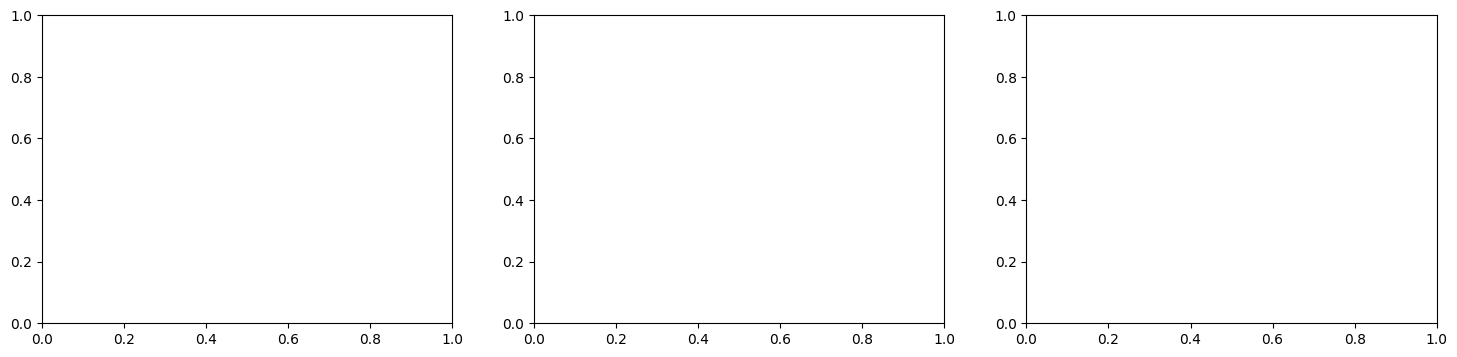

In [48]:
# Iterate over all raw sweeps dataframes and create subplots for each of the 3 types (COD, ROLLOVER, and NO LASER)
for df_raw_sweeps in annotated_sweeps_tables:
    wafer_code = df_raw_sweeps["WAFER_ID"].iloc[0]

    # Scatter plot of PD against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, ax2 = plt.subplots(1, 3, figsize=(18, 4))
    cod_roll_eval_types = ["COD", "ROLLOVER", "NO LASER"]
    colors = ["red", "blue", "orange"]

    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["PD"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of PD vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("PD")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot DP/DI against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["DP/DI"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of DP/DI vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("DP/DI")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Scatter plot of Vf against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["Vf"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of Vf vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("Vf")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot dV/dI against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["dV/dI"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of dV/dI vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("dV/dI")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

Touchdown numbers with COD evaluation for Wafer Code QCHWK: [ 436  829  830 1286 1287 1288]


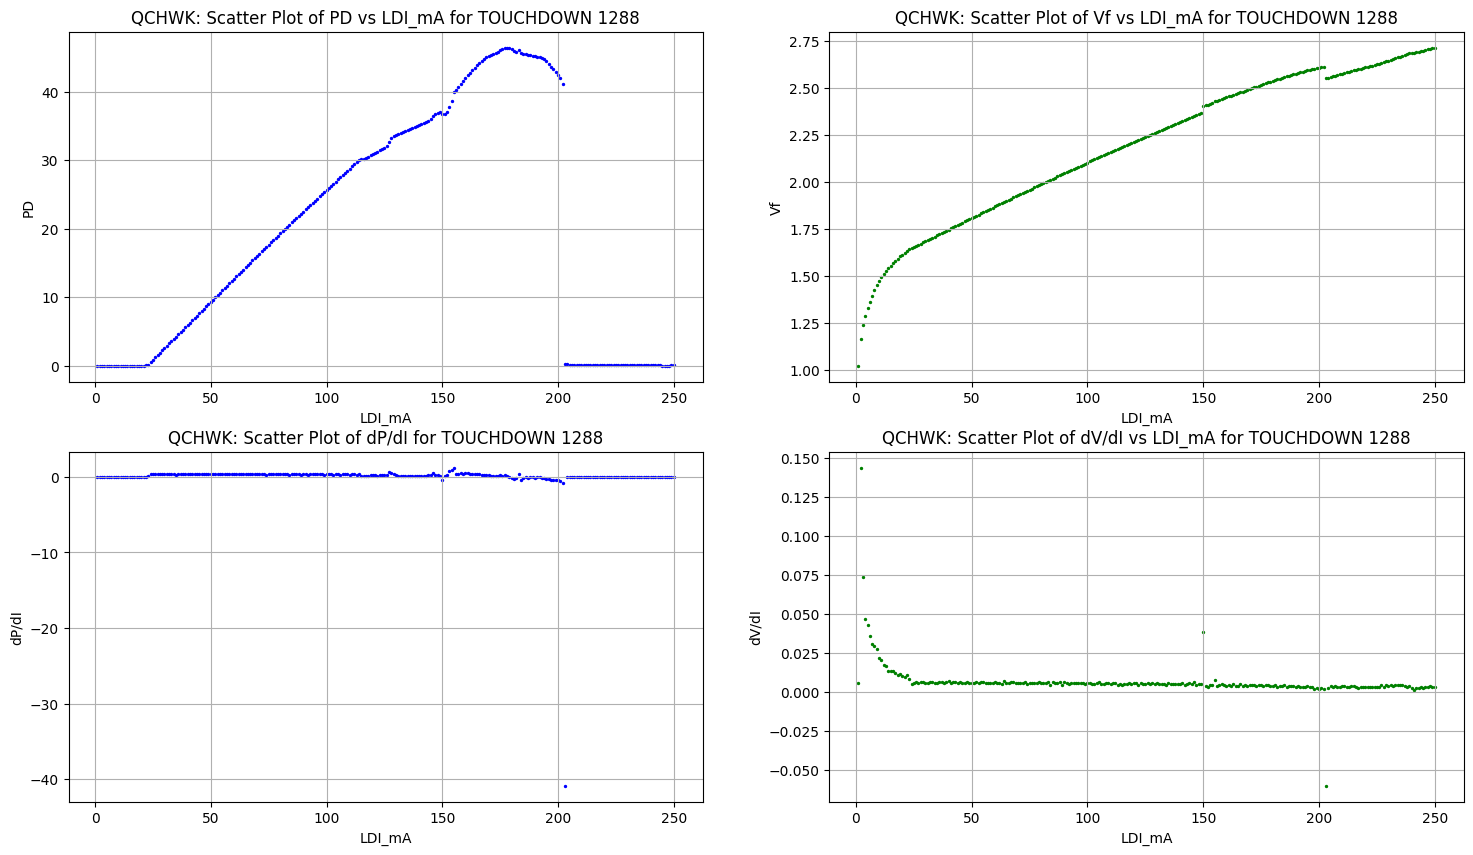

In [13]:
# Function to plot PD/LDI and Vf/LDI for a specific laser and wafer
def plot_specific_touchdown(df_raw_sweeps, wafer_code, touchdown):
    specific_data = df_raw_sweeps[(df_raw_sweeps["WAFER_ID"] == wafer_code) & (df_raw_sweeps["TOUCHDOWN"] == touchdown)]

    if specific_data.empty:
        print(f"No data found for Wafer Code: {wafer_code} and TOUCHDOWN: {touchdown}")
        return

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 10))

    # Plot PD/LDI
    ax1.scatter(specific_data["LDI_mA"], specific_data["PD"], s=2, color="blue")
    ax1.set_title(f"{wafer_code}: Scatter Plot of PD vs LDI_mA for TOUCHDOWN {touchdown}")
    ax1.set_xlabel("LDI_mA")
    ax1.set_ylabel("PD")
    ax1.grid(True)

    # Plot dP/dI
    ax3.scatter(specific_data["LDI_mA"], specific_data["DP/DI"], s=2, color="blue")
    ax3.set_title(f"{wafer_code}: Scatter Plot of dP/dI for TOUCHDOWN {touchdown}")
    ax3.set_xlabel("LDI_mA")
    ax3.set_ylabel("dP/dI")
    ax3.grid(True)

    # Plot Vf/LDI
    ax2.scatter(specific_data["LDI_mA"], specific_data["Vf"], s=2, color="green")
    ax2.set_title(f"{wafer_code}: Scatter Plot of Vf vs LDI_mA for TOUCHDOWN {touchdown}")
    ax2.set_xlabel("LDI_mA")
    ax2.set_ylabel("Vf")
    ax2.grid(True)

    # Plot dV/dI
    ax4.scatter(specific_data["LDI_mA"], specific_data["dV/dI"], s=2, color="green")
    ax4.set_title(f"{wafer_code}: Scatter Plot of dV/dI vs LDI_mA for TOUCHDOWN {touchdown}")
    ax4.set_xlabel("LDI_mA")
    ax4.set_ylabel("dV/dI")
    ax4.grid(True)

    plt.show()


# Define the specific wafer code and TOUCHDOWN number
wafer_code = "QCHWK"
touchdown = 1288  # Replace with the desired TOUCHDOWN number

# Find the correct dataframe where the wafer code matches the input
df_raw_sweeps = None
for df in annotated_sweeps_tables:
    if df["WAFER_ID"].iloc[0] == wafer_code:
        df_raw_sweeps = df
        break

if df_raw_sweeps is not None:
    # Search for touchdown numbers where COD_ROLL_EVAL == COD
    cod_touchdowns = df_raw_sweeps[(df_raw_sweeps["COD_ROLL_EVAL"] == "COD") | (df_raw_sweeps["COD_ROLL_EVAL"] == "M. COD")]["TOUCHDOWN"].unique()
    print(f"Touchdown numbers with COD evaluation for Wafer Code {wafer_code}: {cod_touchdowns}")

    # Plot for the specified touchdown number
    plot_specific_touchdown(df_raw_sweeps, wafer_code, touchdown)
else:
    print(f"No data found for Wafer Code: {wafer_code}")